In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
%store -r X_footsteps_continuous_absolute
%store -r Y_footsteps_continuous_absolute
X_motion = np.concatenate((X_footsteps_accelerations_absolute, X_footsteps_continuous_absolute))
Y_motion = np.concatenate((Y_footsteps_accelerations_absolute, Y_footsteps_continuous_absolute))
print(X_motion.shape)
print(Y_motion.shape)

(6143, 28)
(6143, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where RL swings
idxs = np.where(X_motion[:, 23] == 1)[0]
X_motion_RL_swinging = X_motion[idxs]
Y_motion_RL_swinging = Y_motion[idxs]

## Predict RL foot -> x

In [8]:
X_motion_RL_swinging[0, :]

array([ 0.        ,  0.        ,  0.        ,  0.0041432 ,  0.0423457 ,
        0.03024173,  0.03429287,  0.01092689, -0.01718163,  0.23372421,
        0.17385395, -0.4310693 ,  0.2338856 , -0.18163828, -0.43139871,
       -0.248553  ,  0.1472355 , -0.43021482, -0.24974879, -0.16215332,
       -0.42832897,  0.        ,  1.        ,  1.        ,  0.        ,
        0.1       ,  0.        ,  0.        ])

In [9]:
X_motion_RL_swinging[0, :]

array([ 0.        ,  0.        ,  0.        ,  0.0041432 ,  0.0423457 ,
        0.03024173,  0.03429287,  0.01092689, -0.01718163,  0.23372421,
        0.17385395, -0.4310693 ,  0.2338856 , -0.18163828, -0.43139871,
       -0.248553  ,  0.1472355 , -0.43021482, -0.24974879, -0.16215332,
       -0.42832897,  0.        ,  1.        ,  1.        ,  0.        ,
        0.1       ,  0.        ,  0.        ])

### Linear Regression

In [10]:
# Input
X = np.hstack((X_motion_RL_swinging[:, :3], # prev velocity command
               X_motion_RL_swinging[:, -3:], # commanded velocity command
               X_motion_RL_swinging[:, 9:11], # FL (x,y) position
               X_motion_RL_swinging[:, 12:14], # FR (x,y) position
               X_motion_RL_swinging[:, 15:17], # RL (x,y) position
               X_motion_RL_swinging[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_motion_RL_swinging[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_rl_relative_swinging_x = LinearRegression()

# Fit the model
model_rl_relative_swinging_x.fit(X_train, Y_train)

# Predict
predictions = model_rl_relative_swinging_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.993273200010421
RMSE:  0.003127621586691611
The lowest error is:  5.616089052279394e-06
The highest error is:  0.017345625720877833
The avg. error is:  0.0019082154520228183


In [11]:
model_rl_relative_swinging_x.coef_

array([[ 8.17039826e-03, -1.94289029e-16, -2.22044605e-16,
         2.13054670e-01,  4.51028104e-17, -2.77555756e-17,
        -4.60401692e-02,  4.48879325e-01,  9.54721107e-02,
        -9.97748409e-02, -4.48068086e-01,  9.34014613e-02,
         9.32634567e-02, -5.19054120e-02]])

In [12]:
model_rl_relative_swinging_x.intercept_

array([-0.22238487])

Text(0, 0.5, 'Predictions')

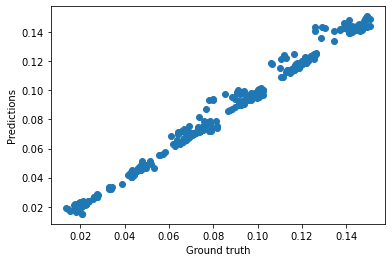

In [13]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [14]:
#%store model_rl_relative_swinging_x

In [15]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [16]:
# Save model
#joblib.dump(model_rl_relative_swinging_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_rl_relative_swinging_x.sav")

### Predict RL foot -> y

In [17]:
# Input
X = np.hstack((X_motion_RL_swinging[:, :3], # prev velocity command
               X_motion_RL_swinging[:, -3:], # commanded velocity command
               X_motion_RL_swinging[:, 9:11], # FL (x,y) position
               X_motion_RL_swinging[:, 12:14], # FR (x,y) position
               X_motion_RL_swinging[:, 15:17], # RL (x,y) position
               X_motion_RL_swinging[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_motion_RL_swinging[:, 3]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_rl_relative_swinging_y = LinearRegression()

# Fit the model
model_rl_relative_swinging_y.fit(X_train, Y_train)

# Predict
predictions = model_rl_relative_swinging_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.5410877245698709
RMSE:  0.0023302478960207057
The lowest error is:  5.676258247433452e-06
The highest error is:  0.011081186597504775
The avg. error is:  0.0014673043316913664


In [18]:
model_rl_relative_swinging_y.coef_

array([[-3.60149148e-04,  9.54097912e-18, -8.32667268e-17,
        -2.80540299e-02, -1.38777878e-17,  2.77555756e-17,
         5.82257984e-02,  7.58113324e-03, -9.15410748e-02,
         1.41373755e-01, -4.93862376e-02, -3.88317439e-01,
         1.10109191e-01,  5.13040273e-03]])

In [19]:
model_rl_relative_swinging_y.intercept_

array([0.10912904])

Text(0, 0.5, 'Predictions')

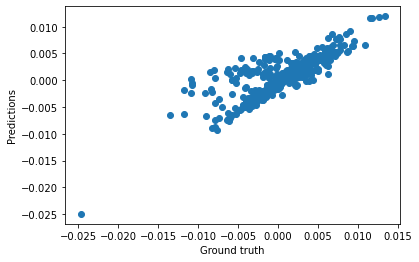

In [20]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [73]:
#%store model_rl_relative_swinging_y

In [74]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [75]:
# Save model
#joblib.dump(model_rl_relative_swinging_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_rl_relative_swinging_y.sav")